<a href="https://colab.research.google.com/github/AylinOndersev/Mask-Detection/blob/main/MASK_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```


# **MASK DETECTION**
With occuring Covid-19,
A new term joins our lives , mask ! 
It protects us from virus if we wear mask correctly.
there is no efficient face mask detection applications so I would like to construct a classification model with images which 3 classes. They are 'yes mask','no mask' and 'wrong mask'. Let's coding and raise awareness of wearning mask.






## Library

In [ ]:
# import the required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from shutil import copyfile
import random

import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model with CNN

### Dataset

In [ ]:
print("The number of images with facemask labelled 'yes':",len(os.listdir('/content/drive/My Drive/data/yesmask')))
print("The number of images with facemask labelled 'wrong':",len(os.listdir('/content/drive/My Drive/data/wrongmask')))
print("The number of images with facemask labelled 'no':",len(os.listdir('/content/drive/My Drive/data/nomask')))

The number of images with facemask labelled 'yes': 472
The number of images with facemask labelled 'wrong': 471
The number of images with facemask labelled 'no': 518


### Split Data Test and Train

In [ ]:
BATCH_SIZE = 64
EPOCHS = 200

# put the list of images in our dataset directory, then initialize
# the list of data and class images
print("loading images...")
imagePaths = list(paths.list_images("/content/drive/My Drive/data"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, random_state=42)

loading images...


### Set Parameter

In [ ]:
model = tf.keras.Sequential(
  [
      #tf.keras.layers.Reshape(input_shape=(224, 224, 3), target_shape=(224, 224, 3)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same',input_shape=(224, 224, 3)),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
   
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
   
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(3, activation='softmax')
  ])



model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 12)      324       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 12)      36        
_________________________________________________________________
activation (Activation)      (None, 224, 224, 12)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 24)      10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 24)      72        
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        2

### Learning Rate Schedule Section

In [ ]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
#plot_learning_rate(lr_decay, EPOCHS)

In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)
# train the head of the network
print("training head...")

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")



Steps per epoch:  937
training head...


### Model

In [ ]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	steps_per_epoch=len(trainX) // BATCH_SIZE,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BATCH_SIZE,
	epochs=EPOCHS)


# make predictions on the testing set
print(" evaluating network...")
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

Epoch 1/200
16/16 [==============================] - 95s 6s/step - loss: 1.2404 - accuracy: 0.5157 - val_loss: 241.2302 - val_accuracy: 0.5055
Epoch 2/200
16/16 [==============================] - 97s 6s/step - loss: 0.8376 - accuracy: 0.5941 - val_loss: 19.3080 - val_accuracy: 0.5314
Epoch 3/200
16/16 [==============================] - 94s 6s/step - loss: 0.7993 - accuracy: 0.6108 - val_loss: 12.1343 - val_accuracy: 0.4945
Epoch 4/200
16/16 [==============================] - 94s 6s/step - loss: 0.7697 - accuracy: 0.6324 - val_loss: 4.2272 - val_accuracy: 0.5314
Epoch 5/200
16/16 [==============================] - 95s 6s/step - loss: 0.7568 - accuracy: 0.6500 - val_loss: 7.0555 - val_accuracy: 0.4354
Epoch 6/200
16/16 [==============================] - 95s 6s/step - loss: 0.7469 - accuracy: 0.6422 - val_loss: 1.5020 - val_accuracy: 0.5424
Epoch 7/200
16/16 [==============================] - 95s 6s/step - loss: 0.7353 - accuracy: 0.6523 - val_loss: 4.9810 - val_accuracy: 0.4170
Epoch 8/2

### Graphics

In [ ]:
import matplotlib.pyplot as plt
def plot_acc_loss(results, epochs):
 acc = results.history['accuracy']
 loss = results.history['loss']
 val_acc = results.history['val_accuracy']
 val_loss = results.history['val_loss']
 plt.figure(figsize=(15, 5))
 plt.subplot(121)
 plt.plot(range(1,epochs), acc[1:], label='Train_acc')
 plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
 plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.subplot(122)
 plt.plot(range(1,epochs), loss[1:], label='Train_loss')
 plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
 plt.title('Loss over ' + str(epochs) +  ' Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.show()
 
plot_acc_loss(history, EPOCHS)

## Model with Tranfer Learning

### Parameters

In [ ]:
# initialize the initial learning rate, number of epochs and batch size
INIT_LR = 1e-4
EPOCHS = 100
BS = 32

### Resize Input Images

In [ ]:
# put the list of images in our dataset directory, then initialize
# the list of data and class images
print("loading images...")
imagePaths = list(paths.list_images("/content/drive/My Drive/data"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)


loading images...


### Split dataset train and test 

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, random_state=42)

### Construct the training image generator

In [ ]:

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

### MobileNetV2 network



In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


### Parameter Optimization and Model

In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
#headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print(" evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))




compiling model...
training head...
Epoch 1/100
33/33 [==============================] - 51s 2s/step - loss: 0.7500 - accuracy: 0.4278 - val_loss: 0.4585 - val_accuracy: 0.6384
Epoch 2/100
33/33 [==============================] - 55s 2s/step - loss: 0.4995 - accuracy: 0.6112 - val_loss: 0.3594 - val_accuracy: 0.7638
Epoch 3/100
33/33 [==============================] - 50s 2s/step - loss: 0.4283 - accuracy: 0.6711 - val_loss: 0.3230 - val_accuracy: 0.7970
Epoch 4/100
33/33 [==============================] - 51s 2s/step - loss: 0.3567 - accuracy: 0.7357 - val_loss: 0.2964 - val_accuracy: 0.8192
Epoch 5/100
33/33 [==============================] - 51s 2s/step - loss: 0.3307 - accuracy: 0.7671 - val_loss: 0.2824 - val_accuracy: 0.7934
Epoch 6/100
33/33 [==============================] - 51s 2s/step - loss: 0.3103 - accuracy: 0.7795 - val_loss: 0.2678 - val_accuracy: 0.8229
Epoch 7/100
33/33 [==============================] - 51s 2s/step - loss: 0.2994 - accuracy: 0.7918 - val_loss: 0.2658 

In [ ]:
saved_model_path = "./my_model.h5"
model.save(saved_model_path) #save your model 

### Graphics

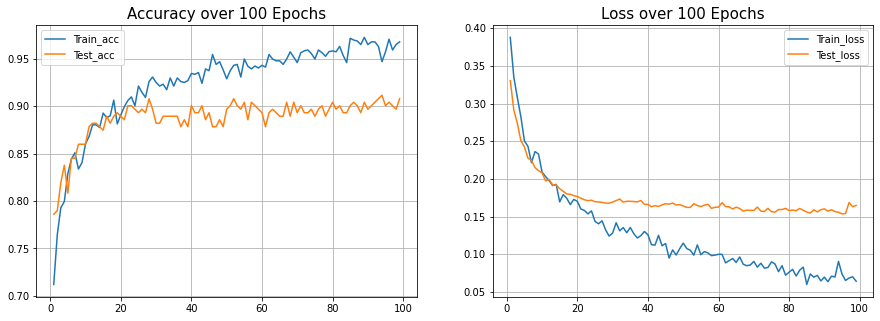

In [ ]:
import matplotlib.pyplot as plt
def plot_acc_loss(results, epochs):
 acc = results.history['accuracy']
 loss = results.history['loss']
 val_acc = results.history['val_accuracy']
 val_loss = results.history['val_loss']
 plt.figure(figsize=(15, 5))
 plt.subplot(121)
 plt.plot(range(1,epochs), acc[1:], label='Train_acc')
 plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
 plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.subplot(122)
 plt.plot(range(1,epochs), loss[1:], label='Train_loss')
 plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
 plt.title('Loss over ' + str(epochs) +  ' Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.show()
 
plot_acc_loss(H, EPOCHS)

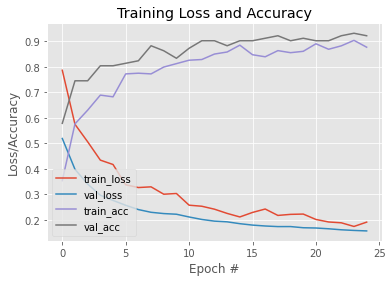

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot")